### Imports

In [1]:
import numpy as np
import math
from math import sqrt
import pandas as pd
import os
import scipy
from scipy import stats, signal
import pickle
import re

import time

import warnings
warnings.filterwarnings("ignore")

### Opening Necessary Files

In [2]:
#pickles file
def pickle_file(file_path, file):
    outfile = open(file_path,'wb')
    pickle.dump(file, outfile)
    outfile.close()

In [3]:
#opens file
def open_pickle(path):
    infile = open(path,'rb')
    file = pickle.load(infile)
    infile.close()
    
    return file

In [4]:
#defines paths
cwd = os.getcwd()
file_dir = os.path.join(cwd, 'files')

In [5]:
#pickled dictionary containing object dataframes for every mouse
#individual dataframes stored as pickled dataframe
all_obj_dict = open_pickle(os.path.join(file_dir, 'flatten_all_obj_dict'))

In [6]:
#pickled dictionary containing parts dataframes for every mouse
#individual dataframes stored as hdf files
all_parts_dict = open_pickle(os.path.join(file_dir, 'all_parts_dict'))

### Calculations

In [7]:
#distance calcs
#two elements each with one (x, y)
def euc_calc(x1, y1, x2, y2):
    xdist = x2 - x1
    ydist = y2 - y1
    dist = sqrt((xdist)**2 + (ydist)**2)
    
    return dist, xdist, ydist

#calculate based off distance measure
def d1(x1, y1, x2, y2):
    return euc_calc(x1, y1, x2[0], y2[0])

#find the distance of each subset of object to the x1,y1 and return the average distance
def d2(x1, y1, x2, y2):
    dists = []
    xdists = []
    ydists = []
        
    for i in range(x2.size):
        d, x, y = euc_calc(x1, y1, x2[i], y2[i])
        dists.append(d)
        xdists.append(x)
        ydists.append(y)
    
    return np.average(np.array(dists)), np.average(np.array(xdists)), np.average(np.array(ydists))

#find the distance of each subset of object to the x1,y1 and return the minimum distance
def d3(x1, y1, x2, y2):
    dists = []
    xdists = []
    ydists = []
    
#     if (x2.size) < 2 or (y2.size) < 2:
#         d, x, y, = euc_calc(x1, y1, x2[0], y2[0])
#         dists.append(d)
#         xdists.append(x)
#         ydists.append(y)
        
#     else:
    for i in range(x2.size):
        d, x, y = euc_calc(x1, y1, x2[i], y2[i])
        dists.append(d)
        xdists.append(x)
        ydists.append(y)
    
    return np.amin(np.array(dists)), np.amin(np.array(xdists)), np.amin(np.array(ydists))

### Constants

In [8]:
MICE_NAMES = ["caf99", "kdr48", "caf42", "caf26"]

In [9]:
FRAME_NUM = {"caf99" : len(all_parts_dict['caf99']), 
            "kdr48" : len(all_parts_dict['kdr48']), 
            "caf42" : len(all_parts_dict['caf42']), 
            "caf26" : len(all_parts_dict['caf26'])}

In [10]:
#key for all encoded objects
ENCODED_OBJS = {0 : "headstage", 1 : "snout", 2 : "body", 3 : "ball", 4 : "pellet", 5 : "brown_nest", 
                6 : "white_nest", 7 : "box", 8 : "food_gel", 9 : "spout", 10 : "porthole"}

#excludes any mouse parts, which should be referenced using the dlc dataframe
#index starts at 3
OBJECTS = ['ball', 'pellet', 'brown_nest', 'white_nest', 'box', 'food_gel', 
           'spout', 'porthole']

In [11]:
#appropriate distance measure to use for each object in relation to body part
#pellet - average distance
#brown_nest, white_nest - minimum distance
#porthole - minimum distance
DIST_PART = {3 : d1, 4 : d2, 5 : d3, 6 : d3, 7 : d1, 8 : d1, 9 : d1, 10 : d3}

In [12]:
#body parts in h5 dlc files
BODY_PARTS = ['base_tail', 'body_core', 'headstage', 'left_ear', 'right_ear', 'snout']

In [13]:
#names of .h5 + .txt files
DLC_NAMES = {"caf99" : "CAF00099-20210608T040846-050846DLC_resnet50_caf26_caf42_caf99_kdr48Jul12shuffle1_1030000.h5",
            "kdr48" : "KDR00048_Top-20220502T201307-211308DLC_resnet50_caf26_caf42_caf99_kdr48Jul12shuffle1_1030000.h5",
            "caf42" : "e3v81a6-20200915T022243-032244DLC_resnet50_caf26_caf42_caf99_kdr48Jul12shuffle1_1030000.h5",
            "caf26" : "e3v81a8-20200808T0609-0709DLC_resnet50_caf26_caf42_caf99_kdr48Jul12shuffle1_1030000.h5"}

OBJ_NAMES = {"caf99" : "CAF00099-20210608T040846-050846", 
            "kdr48" : "KDR00048_Corner-20220502T201304-211305", 
            "caf42" : "e3v81a6-20200915T022243-032244", 
            "caf26" : "e3v81a8-20200808T0609-0709"}

In [14]:
#perspective of video
TOP_DOWN = {"kdr48" : 0, "caf99" : 0, "caf42" : 1, "caf26" : 1}

### Loading in Object and Body Part Identification Information

<b>Step One</b>: Load in all necessary information to a preliminary dataframe. Information is considered "necessary" if it is required to generate features. 

Bones: mouse name, whether or not the video is from the top, the x and y coordinate of the mouse, x and y coordnate of the snout, x and y coordinate of the head centroid (which is the average of the snout, left ear, right ear, and headstage), x and y coordinate of the body core. The video annotations are also loaded in.

In [15]:
def row_avg(cols):
    temp_df = pd.DataFrame()
    
    for i, col in enumerate(cols):
        temp_df[f'col_{i}'] = col
    
    return temp_df.mean(axis=1)     

In [16]:
#loads in all necessary body parts to dataframe
def bones_df(obj_df, dlc_df, mouse_name):
    
    keys = ['dataset_name', 'top_down', 'mouse_x_coord', 'mouse_y_coord', 'snout_x_coord', 
            'snout_y_coord', 'head_centroid_x_coord', 'head_centroid_y_coord', 'body_core_x_coord', 'body_core_y_coord']
    
    mouse_df = pd.DataFrame(columns = keys)
    
    #mouse coordinates from object dataframe
    mouse_df['mouse_x_coord'] = obj_df.loc[obj_df["label"] == "body"]["x_center"].values
    mouse_df['mouse_y_coord'] = obj_df.loc[obj_df["label"] == "body"]["y_center"].values
    
    #snout coordinates from dlc dataframe
    mouse_df['snout_x_coord'] = dlc_df['snout']['x'].values
    mouse_df['snout_y_coord'] = dlc_df['snout']['y'].values
    
    #head centroid from dlc dataframe - average of snout, left ear, right ear, and headstage
    mouse_df['head_centroid_x_coord'] = row_avg([dlc_df['snout']['x'], dlc_df['left_ear']['x'], dlc_df['right_ear']['x'], dlc_df['headstage']['x']])
    mouse_df['head_centroid_y_coord'] = row_avg([dlc_df['snout']['y'], dlc_df['left_ear']['y'], dlc_df['right_ear']['y'], dlc_df['headstage']['y']])
   
    #body core from dlc dataframe
    mouse_df['body_core_x_coord'] = dlc_df['body_core']['x']
    mouse_df['body_core_y_coord'] = dlc_df['body_core']['y']
    
    #fills entire column with mouse name and whether top down 
    mouse_df['dataset_name'] = mouse_name
    mouse_df['top_down'] = TOP_DOWN[mouse_name]
    
    #annotations
    ant_dir = (os.path.join(os.getcwd(), 'annotations'))
    loc_arr_dir = (os.path.join(ant_dir, f'{mouse_name}_loc_arr'))
    reg_arr_dir = (os.path.join(ant_dir, f'{mouse_name}_reg_arr'))

    loc = open_pickle(loc_arr_dir)
    reg = open_pickle(reg_arr_dir)

    mouse_df['loc_behavior'] = loc
    mouse_df['reg_behavior'] = reg

    return mouse_df

<b>Step Two</b>: Perform distance calculations to generate features.

In [17]:
#euclidean distance 
#parameters are difference arrays
def euc_dist(arr_delta_x, arr_delta_y):
    return np.sqrt((arr_delta_x ** 2) + (arr_delta_y ** 2))

Distance against itself in different points in time.

In [18]:
#only performs euclidean distance calculations
def diff_cols(col_x, col_y, col_name, df, col_x2 = None, col_y2 = None, delta = None, keep = False):
    #finds difference between self given shift
    if delta != None:
        diff_x = col_x - col_x.shift(delta)
        diff_y = col_y - col_y.shift(delta)
        col_name = f'{col_name}_by_{delta}f'
    
    #finds difference between two different columns
    else:
        diff_x = col_x2 - col_x
        diff_y = col_y2 - col_y
        col_name = f'DDIST{col_name}'
    
    #put column into dataframe
    if keep == True:
        if delta != None:
            df[f'{col_name}_dx_by_{delta}f'] = diff_x
            df[f'{col_name}_dy_by_{delta}f'] = diff_y
        
        else:
            df[f'XDIST{col_name}'] = diff_x
            df[f'YDIST{col_name}'] = diff_y

    #find euclidean distance between two arrays
    df[col_name] = euc_dist(diff_x, diff_y)
    
    return df

- <b>dxy of mouse and every object
- <b>dxy of snout and every object
- <b>dyx of centroid and every object</b>

In [19]:
#assuming flattened obj df
def parts_dxy(obj_df, mouse_df, body_part):
    #x and y values for body part for all frames
    xmouse = mouse_df[f'{body_part}_x_coord'].values
    ymouse = mouse_df[f'{body_part}_y_coord'].values
    
    total_frames = len(mouse_df)
    
    #iterate through every object
    for obj in OBJECTS:
        dist_list = []
        xdist_list = []
        ydist_list = []
        
        none_list = [None] * total_frames
        
        #isolated dataframe to object
        ind_obj_df = obj_df.loc[obj_df["label"] == obj]
        
        #if object does not exist in dataframe, forgo for loop
        if len(ind_obj_df) < 1:
            mouse_df[f'DDIST{body_part}_to_{obj}'] = none_list
            mouse_df[f'XDIST{body_part}_to_{obj}'] = none_list
            mouse_df[f'YDIST{body_part}_to_{obj}'] = none_list
        
        else:
            #iterate through each frame for each object
            for frame in range(total_frames):
                frame_obj_df = ind_obj_df.loc[ind_obj_df['frame'] == frame]
                
                #if object does not exist in specific frame, append None
                if len(frame_obj_df) < 1:
                    dist_list.append(None)
                    xdist_list.append(None)
                    ydist_list.append(None)
                
                else:
                    xmouse_frame = xmouse[frame]
                    ymouse_frame = ymouse[frame]
                    
                    xobj_frame = frame_obj_df['x_center'].values
                    yobj_frame = frame_obj_df['y_center'].values

                    encoded = OBJECTS.index(obj) + 3
                    dist, xdist, ydist = DIST_PART[encoded](xmouse_frame, ymouse_frame, xobj_frame, yobj_frame)
                    
                    dist_list.append(dist)
                    xdist_list.append(xdist)
                    ydist_list.append(ydist)

            mouse_df[f'DDIST{body_part}_to_{obj}'] = dist_list
            mouse_df[f'XDIST{body_part}_to_{obj}'] = xdist_list
            mouse_df[f'YDIST{body_part}_to_{obj}'] = ydist_list
        
    return mouse_df

<b>Step Three</b>: Add in median filtering.

In application, the median filtering is applied to any features that indicate some change from one point in time to another. For example, distance between body part at time 1 and body part at time 2.

In [20]:
#calculate median_filter
def median_filter(df, col_name, filter_length):
    values = df[col_name].values
    if all(x is None for x in values):
        return [None] * len(values)
    return scipy.signal.medfilt(values, filter_length)

def median_filters(df, col_name, filter_lengths):
    ff_lengths = [int(x * 15) if int(x * 15)%2 == 1 else int((x* 15) - 1) for x in filter_lengths]
    for i, ff_length in enumerate(ff_lengths):
        df[f'median_filter_{col_name}_{filter_lengths[i]}s'] = median_filter(df, col_name, ff_length)
        
    return df

In [21]:
def run_mf(col_names, mf_lengths, mouse_df):
    for col_name in col_names:
        mouse_df = median_filters(mouse_df, col_name, mf_lengths)
    return mouse_df

<b>Step Four</b>: Encode mice names.

In [22]:
def encode_and_bind(df, feature_to_encode):
    
    # Get one hot encoding of columns B
    one_hot = pd.get_dummies(df[feature_to_encode])
    # Drop column B as it is now encoded
    #df = df.drop(feature_to_encode ,axis = 1)
    # Join the encoded df
    df = df.join(one_hot)
    
#     dummies = pd.get_dummies(df[[feature_to_encode]])
#     res_df = pd.concat([df, dummies], axis=1)
#     res_df = res_df.drop([feature_to_encode], axis=1)
    return df

<b>Final Step</b>: Combine all previous methods to create final dataframe w/ needed information and features.

In [23]:
def generate_classification_df(all_obj_dict, all_parts_dict):
    #stores all dataframes, which are concated as the final step
    dataframes = []
    start_time = time.time()
    
    #iterates through each mouse and generates features individually
    for mouse_name in MICE_NAMES:
        print(mouse_name)
        
        #load in individual dataframes
        mouse_obj_df = all_obj_dict[mouse_name]
        mouse_parts_df = all_parts_dict[mouse_name]
        
        mouse_df = bones_df(mouse_obj_df, mouse_parts_df, mouse_name)
        
        #1, 3, 5 seconds; 1 frame - mouse_travel
        shifts = [[1, True], [15, False], [45, False], [75, False]]

        for shift in shifts:
            col_x = mouse_df['mouse_x_coord']
            col_y = mouse_df['mouse_y_coord']
            mouse_df = diff_cols(col_x, col_y, 'mouse_travel', mouse_df, delta = shift[0], keep = shift[1])
        
        #change in body parts
        for body_part in BODY_PARTS:
            part_df = mouse_parts_df[body_part]

            col_x = part_df['x']
            col_y = part_df['y']
            
            #difference in x, y and distance of each body part
            mouse_df = diff_cols(col_x, col_y, body_part, mouse_df, delta = 1, keep = True) 

            for against_part in BODY_PARTS:
                if body_part != against_part:
                    against_part_df = mouse_parts_df[against_part]

                    col_x2 = against_part_df['x']
                    col_y2 = against_part_df['y']
                    
                    #dxy between every body part
                    mouse_df = diff_cols(col_x, col_y, f'{body_part}_to_{against_part}', mouse_df, col_x2 = col_x2, col_y2 = col_y2)

                else:
                    continue
                    
        #dxy between body_core, tail to head_centroid
        parts = ['body_core', 'base_tail']

        for part in parts:
            part_df = mouse_parts_df[part]

            mouse_df = diff_cols(part_df['x'], part_df['y'], f'{body_part}_to_head_centroid', mouse_df, col_x2 = mouse_df['head_centroid_x_coord'], col_y2 = mouse_df['head_centroid_y_coord'], keep = True)
        
#         #dxy between parts and objects
        obj_parts = ['mouse', 'snout', 'head_centroid']
        
        for part in obj_parts:
            mouse_df = parts_dxy(mouse_obj_df, mouse_df, part)
            
        #median filtering
        mf_lengths = [0.5, 1, 2, 3, 4, 5, 10] #median filtering lengths
        col_names = [col for col in mouse_df for name in ['DDIST', 'XDIST', 'YDIST'] if col.startswith(name)]
        
        mouse_df = run_mf(col_names, mf_lengths, mouse_df)
        
        #encoding
        mouse_df = encode_and_bind(mouse_df, 'dataset_name')
        
        #completed dataframe for individual mouse
        dataframes.append(mouse_df)
    
        print(time.time() - start_time)
    
    #combine all individual dataframes together
    final_dataframe = pd.concat(dataframes)
    
    return final_dataframe

### Generating Final Dataframe

In [25]:
final_features_df = generate_classification_df(all_obj_dict, all_parts_dict)

caf99
1177.445121049881
kdr48
1617.85378408432
caf42
2083.243875980377
caf26
2642.736499071121


In [26]:
pickle_file(os.path.join(file_dir, 'features_df'), final_features_df)

### Analysis

- create location based behaviors stripplot distance
- mouse object, head centroid, snout

In [105]:
import seaborn as sns

0        325.233841
1        319.902667
2        311.391654
3        293.558282
4        294.052473
            ...    
53995    423.489766
53996    420.868931
53997    421.261708
53998    421.655030
53999    417.453460
Name: DDISTmouse_to_spout, Length: 270031, dtype: float64

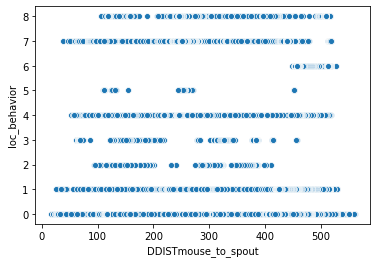

In [28]:
import seaborn as sns
x = final_features_df['DDISTmouse_to_spout']
y = final_features_df['loc_behavior']
sns.scatterplot(x, y)
x

In [112]:
col_names = [col for col in mouse_df for name in ['DDISTmouse', 'DDISTsnout', 'DDISThead'] if col.startswith(name)]

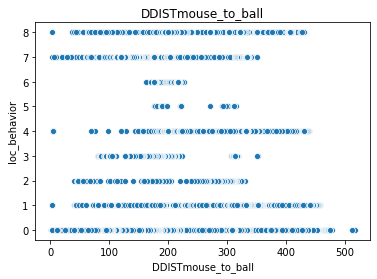

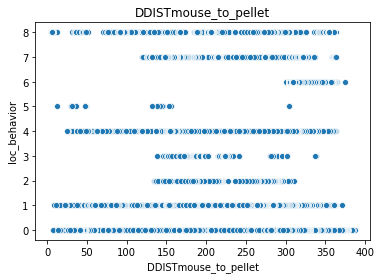

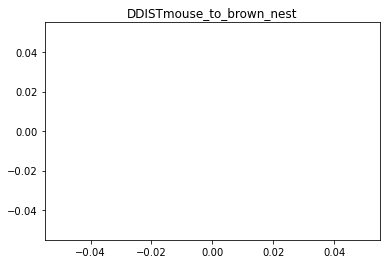

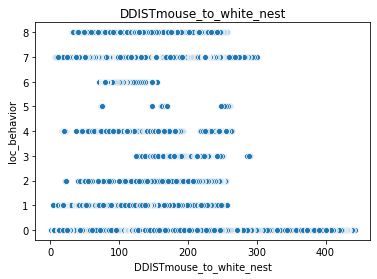

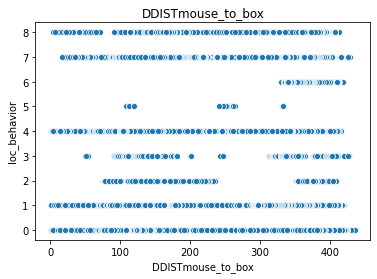

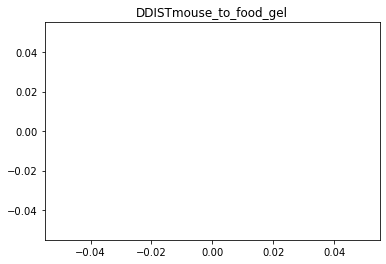

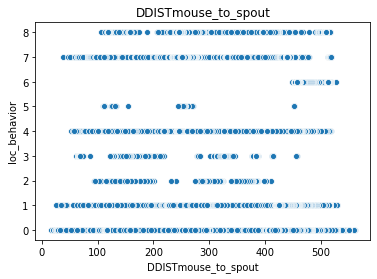

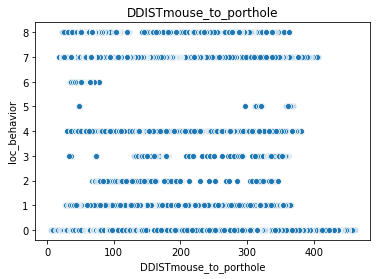

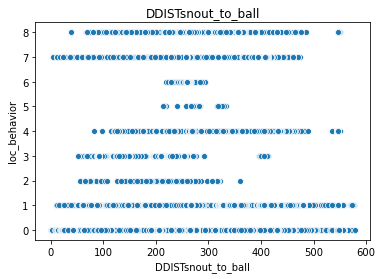

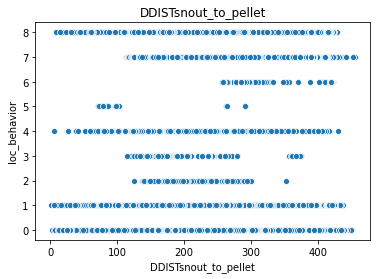

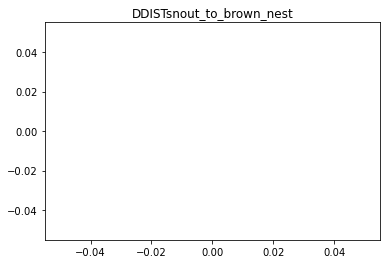

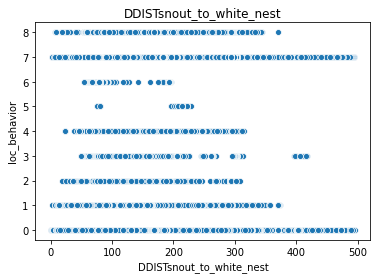

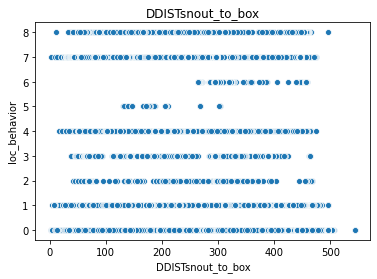

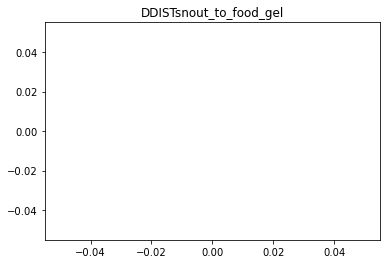

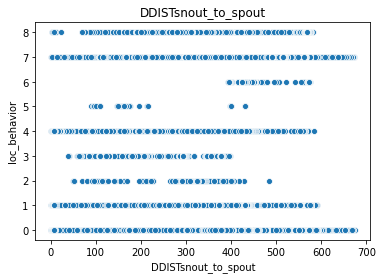

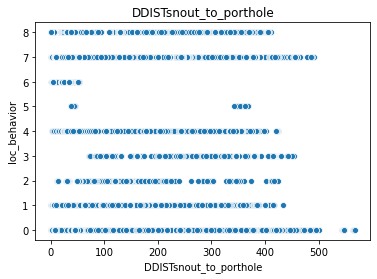

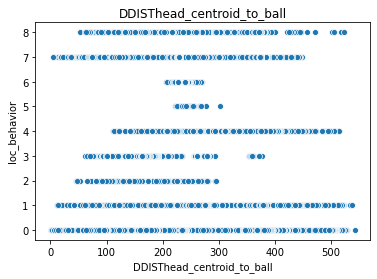

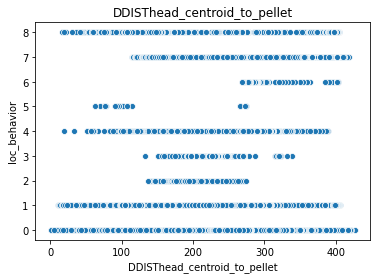

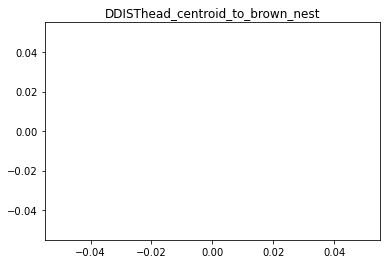

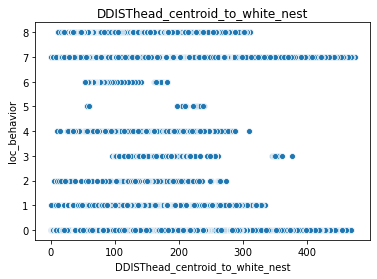

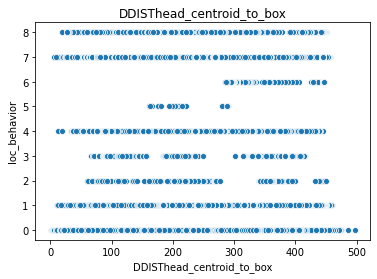

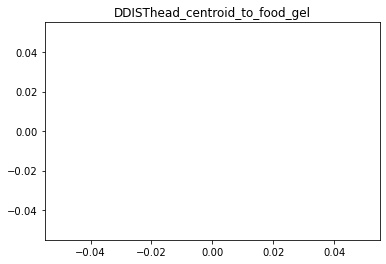

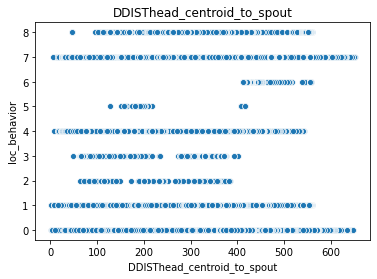

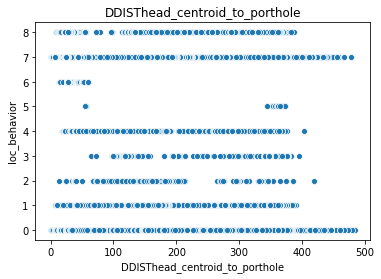

In [254]:
for col in col_names:
    plt.figure()
    plt.title(col)
    x = final_features_df[col]
    x_max = np.amax(x)
    x_normalize = x/x_max
    y = np.zeros_like(x)
    colors = final_features_df['loc_behavior']
    
    val = 0
    sns.scatterplot(x, colors)
    plt.show()

### Dead Code

In [19]:
# #given the dlc h5 path, a dataframe is read in, coordinates are normalized
# def load_dlc(dlc_path):
#     dlc_df = pd.read_hdf(dlc_path)
#     scorer = dlc_df.columns.levels[0][0]
#     dlc_df = dlc_df[scorer]
    
#     body_parts = np.unique([i[0] for i in list(dlc_df.keys())])
    
#     idx = pd.IndexSlice
    
#     for part in body_parts:
#         dlc_df.loc[:, idx[part, 'x']] = dlc_df[part]['x'] / 640
#         dlc_df.loc[:, idx[part, 'y']] = dlc_df[part]['y'] / 480
    
#     return dlc_df, body_parts

In [64]:
# #used dictionary to load in all information
# def parts_df(obj_dict, dlc_df, mouse_name):
#     keys = ["dataset_name", "top_down", "mouse_x_coord", "mouse_y_coord", "snout_x_coord", "snout_y_coord", 
#            "head_centroid_x_coord", "head_centroid_y_coord", "body_core_x_coord", "body_core_y_coord"]
    
#     info = {k: [] for k in keys}
    
#     for key, value in obj_dict.items():
#         #get frame of dlc_df
#         dlc_frame_df = dlc_df.iloc[key]
        
#         #mouse name, top down
#         info["dataset_name"].append(mouse_name)
#         info["top_down"].append(TOP_DOWN[mouse_name])
        
#         #x + y coord of mouse box
#         xmouse = value[value["object"] == 2]["x_center"].values
#         ymouse = value[value["object"] == 2]["y_center"].values
        
#         info['mouse_x_coord'].append(xmouse[0] if len(xmouse > 0) else None)
#         info['mouse_y_coord'].append(ymouse[0] if len(ymouse > 0) else None)
        
#         #x + y coord of snout
#         xsnout = dlc_frame_df['snout'].x
#         ysnout = dlc_frame_df['snout'].y 

#         info['snout_x_coord'].append(xsnout)
#         info['snout_y_coord'].append(ysnout)
        
#         #calculate centroid 
#         xcentroid = np.average(np.array((xsnout, dlc_frame_df['left_ear'].x, dlc_frame_df['right_ear'].x, dlc_frame_df['headstage'].x)))
#         ycentroid = np.average(np.array((ysnout, dlc_frame_df['left_ear'].y, dlc_frame_df['right_ear'].y, dlc_frame_df['headstage'].y)))
        
#         info['head_centroid_x_coord'].append(xcentroid)
#         info['head_centroid_y_coord'].append(ycentroid)
    
#         #get and add body_core coords to dictionary
#         xbody = dlc_frame_df['body_core'].x
#         ybody = dlc_frame_df['body_core'].y
        
#         info['body_core_x_coord'].append(xbody)
#         info['body_core_y_coord'].append(ybody)
    
#     df = pd.DataFrame.from_dict(info, orient='index').transpose()
    
#     return df

In [7]:
# #delta calcs
# #delta between given values
# def delta(df, col, final_frame, block_frame, final_value):
#     initial_frame = final_frame - block_frame
    
#     if initial_frame < 0:
#         return None

#     else:
#         initial_value = df[col].iloc[initial_frame]
#         return final_value - initial_value
    
# #delta distance
# def delta_dist(df, finalx, finaly, final_frame, block_frame):
#     initial_frame = final_frame - block_frame
    
#     if initial_frame < 0:
#         return None
    
#     else:
#         final_coords = np.array((finalx, finaly))
#         initial_coords = np.array((df['mouse_x_coord'].iloc[initial_frame], df['mouse_y_coord'].iloc[initial_frame]))
        
#         return np.linalg.norm(final_coords - initial_coords)

# def delta_travel(df, finalx, finaly, final_frame, block_seconds):
#     delta_travel = {}
    
#     for block_second in block_seconds:
#         block_frame = block_second * 15
#         delta_travel[block_second] = delta_dist(df, finalx, finaly, final_frame, block_frame)
    
#     return delta_travel

In [114]:
# #consolidates both body parts and object procedures
# #dlc_df should already be read in external from this function - dlc_frame_df is the dataframe information for corresponding frame as obj_path refers to 
# def preds_analysis(obj_path, dlc_df, body_parts, video_name, idx, df, mouse_name):
# #     #create dictionary to load into given df
# #     info = {}
    
# #     #loads in df
# # #     dlc_df, body_parts = load_dlc(dlc_path)
# # #     video_name = dlc_path.split("/")[-1].split("DLC")[0] + ".mp4"
    
# #     #adjusts frame of dlc_df
# #     dlc_frame_df = dlc_df.iloc[idx]
    
# #     #read in .txt file
# #     obj_header = ["object", "x_center", "y_center", "width", "height", "likelihood"]
# #     objs_df = pdos.path.join(file_dir, 'caf99_obj_df').read_csv(obj_path, sep = " ", names = obj_header, header = None)

# #     #mouse_name
# #     info["dataset_name"] = mouse_name
    
# #     #perspective (0 for no, 1 for yes)
# #     info["top_down"] = top_down[mouse_name]
    
# #     #current index
# #     cur_idx = len(df)
    
# #     #get and add mouse coords to dictionary
# #     xmouse = objs_df[objs_df["object"] == 2]["x_center"].values[0] if (len(objs_df[objs_df["object"] == 2]["x_center"].values) > 0) else return df
# #     ymouse = objs_df[objs_df["object"] == 2]["y_center"].values[0] if (len(objs_df[objs_df["object"] == 2]["y_center"].values) > 0) else return df
    
# #     info['mouse_x_coord'] = xmouse
# #     info['mouse_y_coord'] = ymouse
    
# #     #get and add snout coords to dictionary
# #     xsnout = dlc_frame_df['snout'].x if dlc_frame_df['snout'].x != None else return df
# #     ysnout = dlc_frame_df['snout'].y if dlc_frame_df['snout'].y != None else return df
    
# #     info['snout_x_coord'] = xsnout
# #     info['snout_y_coord'] = ysnout
    
# #     #calculates average x, y of snout, left ear, right ear and headstage
# #     #adds head centroid to dictionary
# #     to_centroid = ['base_tail', 'body_core']
    
# #     xcentroid = np.average(np.array((dlc_frame_df['snout'].x, dlc_frame_df['left_ear'].x, dlc_frame_df['right_ear'].x, dlc_frame_df['headstage'].x)))
# #     ycentroid = np.average(np.array((dlc_frame_df['snout'].y, dlc_frame_df['left_ear'].y, dlc_frame_df['right_ear'].y, dlc_frame_df['headstage'].y)))
# #     info['head_centroid_x_coord'] = xcentroid
# #     info['head_centroid_y_coord'] = ycentroid
    
# #     #get and add body_core coords to dictionary
# #     xbody = dlc_frame_df['body_core'].x
# #     ybody = dlc_frame_df['body_core'].y
    
# #     #dx + dy + d_dist
# #     info['mouse_dx_coord'] = delta(df, 'mouse_x_coord', cur_idx, 1, xmouse)
# #     info['mouse_dy_coord'] = delta(df, 'mouse_y_coord', cur_idx, 1, ymouse)
# #     info['mouse_ddist'] = delta_dist(df, xmouse, ymouse, cur_idx, 1)
    
# #     #mouse_travel: 1, 3, 5 - adjust for fps later
#     mouse_travel_blocks = [1, 3, 5]
#     mouse_travel = delta_travel(df, xmouse, ymouse, cur_idx, mouse_travel_blocks)
    
#     for block in mouse_travel_blocks:
#         info[f'mouse_travel_{block}s'] = mouse_travel[block]
    
#     #iterates through all body parts
#     for part in body_parts:
#         xpart_one = dlc_frame_df[part].x
#         ypart_one = dlc_frame_df[part].y
        
#         #dx + dy + d_dist
#         info[f'{part}_dx_coord'] = delta(dlc_df[part], 'x', cur_idx, 1, xmouse)
#         info[f'{part}_dy_coord'] = delta(dlc_df[part], 'y', cur_idx, 1, ymouse)
        
#         #distance between given part and head centroid
#         if part in to_centroid:
#             partcdist, partcxdist, partcydist = part_calc(xpart_one, ypart_one, xcentroid, ycentroid)
#             info[f'D{part}_to_head_centroid'] = partcdist
#             info[f'X{part}_to_head_centroid'] = partcxdist
#             info[f'Y{part}_to_head_centroid'] = partcydist
        
#         #distance between every body part against every body part
#         for every_part in body_parts:
#             if every_part == part:
#                 continue
#             else:
#                 xpart_two = dlc_frame_df[every_part].x
#                 ypart_two = dlc_frame_df[every_part].y
                
#                 part_dist, _, _ = part_calc(xpart_one, ypart_one, xpart_two, ypart_two)
                
#                 info[f'D{part}_to_{every_part}'] = part_dist
    
#     #distance between objects and objects / objects and parts
#     for obj in encoded_objs:
#         obj_df = objs_df[objs_df["object"] == obj]
#         obj_coords = np.array((obj_df["x_center"].values, obj_df["y_center"].values))

#         if obj_df.empty:
#             all_dists = ['{}{}{}'.format(m, bp, obj) for m in 'DXY' for bp in 'MBS']
#             info.update(dict.fromkeys(all_dists, None))
        
#         else:
#             #between mouse and object
#             mdist, mxdist, mydist = dist_key[obj](xmouse, ymouse, obj_coords)
            
#             #between a body part and object
#             bdist, bxdist, bydist = dist_obj[obj](xbody, ybody, obj_coords)
#             sdist, sxdist, sydist = dist_part[obj](xsnout, ysnout, obj_coords)
#             cdist, cxdist, cydist = dist_part[obj](xcentroid, ycentroid, obj_coords)
            
#             info[f'DM{obj}'] = mdist
#             info[f'XM{obj}'] = mxdist
#             info[f'YM{obj}'] = mydist
            
#             info[f'DB{obj}'] = bdist
#             info[f'XB{obj}'] = bxdist
#             info[f'YB{obj}'] = bydist
            
#             info[f'DS{obj}'] = sdist
#             info[f'XS{obj}'] = sxdist
#             info[f'YS{obj}'] = sydist
            
#             info[f'DC{obj}'] = cdist
#             info[f'XC{obj}'] = cxdist
#             info[f'YC{obj}'] = cydist
    
#     return df.append(info, ignore_index = True)

In [208]:
# #loads in all necessary body parts to dataframe
# def bones_df(obj_dict, dlc_df, mouse_name):
#     keys = ["dataset_name", "top_down", "mouse_x_coord", "mouse_y_coord", "snout_x_coord", "snout_y_coord", 
#            "head_centroid_x_coord", "head_centroid_y_coord", "body_core_x_coord", "body_core_y_coord"]
    
#     info = []
    
#     for key, frame in range(obj_dict):
#         row = []
        
#         #get frame of dlc_df
#         dlc_frame_df = dlc_df.iloc[key]
        
#         #mouse name, top down
#         row.append(mouse_name)
#         row.append(TOP_DOWN[mouse_name])
        
#         #x + y coord of center of mouse box
#         xmouse = frame[frame["object"] == 2]["x_center"].values
#         ymouse = frame[frame["object"] == 2]["y_center"].values
        
#         row.append(xmouse[0] if len(xmouse > 0) else None)
#         row.append(ymouse[0] if len(ymouse > 0) else None)
        
#         #x + y coord of snout
#         xsnout = dlc_frame_df['snout'].x
#         ysnout = dlc_frame_df['snout'].y 

#         row.append(xsnout)
#         row.append(ysnout)
        
#         #calculate centroid 
#         xcentroid = np.average(np.array((xsnout, dlc_frame_df['left_ear'].x, dlc_frame_df['right_ear'].x, dlc_frame_df['headstage'].x)))
#         ycentroid = np.average(np.array((ysnout, dlc_frame_df['left_ear'].y, dlc_frame_df['right_ear'].y, dlc_frame_df['headstage'].y)))
        
#         row.append(xcentroid)
#         row.append(ycentroid)
    
#         #get and add body_core coords to dictionary
#         xbody = dlc_frame_df['body_core'].x
#         ybody = dlc_frame_df['body_core'].y
        
#         row.append(xbody)
#         row.append(ybody)
        
#         info.append(row)
                   
#     df = pd.DataFrame(info, columns = keys)
    
#     ant_dir = (os.path.join(os.getcwd(), 'annotations'))
#     loc_arr_dir = (os.path.join(ant_dir, f'{mouse_name}_loc_arr'))
#     reg_arr_dir = (os.path.join(ant_dir, f'{mouse_name}_reg_arr'))
    
#     df['loc_beh'] = open_pickle(loc_arr_dir) if mouse_name != "caf99" else None
#     df['reg_beh'] = open_pickle(reg_arr_dir) if mouse_name != "caf99" else None
    
#     return df

In [18]:
# def parts_dxy(obj_df, mouse_df, frame_num, body_part):
#     #x and y values for body part for all frames
#     xmouse = mouse_df[f'{body_part}_x_coord'].values
#     ymouse = mouse_df[f'{body_part}_y_coord'].values
    
#     #iterate through every object
#     for obj in OBJECTS:
# #         print(obj)
#         dist_list = []
#         xdist_list = []
#         ydist_list = []
#         none_list = [None] * frame_num
        
#         dists_list = [dist_list, xdist_list, ydist_list]
        
#         #x and y values for object for all frames
#         ind_obj_df = obj_df.loc[obj_df["label"] == obj]
#         xobj = ind_obj_df["x_center"]
#         yobj = ind_obj_df["y_center"]
        
# #         frames = ind_obj_df.index
# #         idxs = [i[0] for i in frames]
        
# #         print(len(xobj))
        
#         if len(ind_obj_df) < 1:
#             mouse_df[f'DDIST{body_part}_to_{obj}'] = none_list
#             mouse_df[f'XDIST{body_part}_to_{obj}'] = none_list
#             mouse_df[f'YDIST{body_part}_to_{obj}'] = none_list
        
#         else:
#             #for each object, iterate through each frame:
#             for frame in range(frame_num):
#                 xmouse_frame = xmouse[frame]
#                 ymouse_frame = ymouse[frame]

# #                 if frame in idxs:
#                 xobj_frame = xobj[frame].values
#                 yobj_frame = yobj[frame].values

#                 encoded = OBJECTS.index(obj) + 3
#                 dist, xdist, ydist = DIST_PART[encoded](xmouse_frame, ymouse_frame, xobj_frame, yobj_frame)
#                 [x.append(y) for x,y in zip(dists_list, [dist, xdist, ydist])]
                
# #                 else:
# #                     [x.append(y) for x,y in zip(dists_list, [None, None, None])]

#             mouse_df[f'DDIST{body_part}_to_{obj}'] = dist_list
#             mouse_df[f'XDIST{body_part}_to_{obj}'] = xdist_list
#             mouse_df[f'YDIST{body_part}_to_{obj}'] = ydist_list
        
#     return mouse_df